# Implementing LSM

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from time import time

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float,
                 dim: int, n: int, seed: int):
        """ Class for pricing American OptionsLSM. 
        
        Parameters: 
        S0 (float): Initial asset value
        K (float): strike price
        T (float): time to maturity, in years, a float number
        r (float): risk-free interest rate
        σ (float): volatility coefficient for diffusion
        dim (int): number of paths to simulate
        n (int): between time 0 and time T, the number of time steps 
        """
        
        assert σ >= 0, 'volatility cannot be less than zero'
        assert S0 >= 0, 'initial stock price cannot be less than zero'
        assert T >= 0, 'time to maturity cannot be less than zero'
        assert n >= 0, 'no. of slices per year cannot be less than zero'
        assert dim >= 0, 'no. of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.dim = dim
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r*self.Δ)
        self.Z = np.random.normal(0, 1, (self.dim, self.n-1)) # white noise (drawn all at once)
        self.S = np.full((self.dim, self.n), np.nan)  # Allocate space for stock price process, with an extra step for initial value

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[:,0] = np.log(S0)  # Set initial values
        for j in range(1,n):
            S[:,j] = S[:,j-1] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,j-1]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def GeometricBrownianMotion_vec(self):
        """ Generate GBM paths according to Algorithm 3.

        Returns:
        np.ndarray: Simulated paths of the asset price.
        """

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n

        # Generate all increments at once
        BM = (r - 0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z
        
        # Use cumsum to calculate the cumulative sum of increments and then exponentiate
        S[:,:] = np.log(S0)
        S[:,1:] += np.cumsum(BM, axis=1)

        # Multiply every path by the initial stock price
        self.S = np.exp(S)
        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[:,0] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        
        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes
        
        for j in range(1,n):
            # Compute jump sizes for each path
            M = α*N[:,j-1] + β*np.sqrt(N[:,j-1])*Z_2[:,j-1]
            # if no jump set jump process to zero 
            M = np.where(N[:,j-1] > 0, M, 0)
            # Calculate the combined diffusion and jump process
            S[:,j] = S[:,j-1] + c*Δ + σ*np.sqrt(Δ)*Z[:,j-1] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def MertonJumpDiffusion_vec(self, α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim
        
        # No changes up to the definition of c
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)

        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes

        # Calculate the jump sizes for all paths and time steps
        M = α * N + β*np.sqrt(N)*Z_2
        
        # if no jump set M = 0
        M = np.where(N > 0, M, 0)
        
        # Calculate the combined diffusion and jump process for all time steps
        S[:,:] = np.log(S0)
        S[:,1:] = np.log(S0) + np.cumsum(c*Δ + σ*np.sqrt(Δ)*Z + M, axis=1)

        self.S = np.exp(S)

        return self.S

    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = γ

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[:,0] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for j in range(1,n):
            S[:,j] = S[:,j-1] + r*S[:,j-1]*Δ + σ*S[:,j-1]**(γ/2)*np.sqrt(Δ)*Z[:,j-1]
        self.S = S

        return self.S
    
    def BS_option_value(self, otype: str = 'put'):
        ''' Closed-form valuation of a European option in Black-Scholes.
        
        Parameters:
        otype (str): Option type either call or put (defualt: put)
        
        Returns:
        float: Option price of a European put option
        '''
        
        # unpack 
        S0 = self.S0
        K = self.K
        r = self.r
        σ = self.σ
        T = self.T

        d1 = (np.log(S0/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))
        d2 = d1 - σ*np.sqrt(T)
        
        if otype == 'call':
            value = (S0 * stats.norm.cdf(d1, 0., 1.) -
                 K * np.exp(-r * T)*stats.norm.cdf(d2, 0., 1.))
        elif otype == 'put':
            value = K * np.exp(-r*T)*stats.norm.cdf(-d2) - S0*stats.norm.cdf(-d1)
        else: 
            raise ValueError('Invalid option type.')
    
        return value
    
    def american_option_LSM(self, poly_degree: int, otype: str = 'put'):
        """
        American option pricing using the LSM as outlined in Algorithm 1.
        
        Parameters:
        poly_degree (int): x^n, number of basis functions
        otype (str): call or put (default)
        
        Returns:
        float: V0, LSM Estimator
        """
        
        assert otype == 'call' or otype == 'put', 'Invalid option type.'
        assert len(self.S) != 0, 'Please simulate a stock price process.'
        
        # unpack
        S = self.S
        K = self.K
        S0 = self.S0
        n = self.n
        dim = self.dim
        df = self.df
        
        # inner values
        if otype == 'call':
            self.intrinsic_val = np.maximum(S - K, 0)
        elif otype == 'put':
            self.intrinsic_val = np.maximum(K - S, 0)
            
        # last day cashflow == last day intrinsic value
        V = np.copy(self.intrinsic_val[:,-1])

        # Backward Induction
        for i in range(n - 2, 0, -1): # start at second to last and end at second to first
            # a. find itm path 
            # (potentially) better estimate the continuation value
            itm_path = np.where(self.intrinsic_val[:,i]>0)  # evaluate: S[:,i] vs. K
            V = V * df # discount next period value
            V_itm = V[itm_path[0]] # define subset (note, we need to set [0] due to np.where being tuple)
            S_itm = S[itm_path[0],i]
            
            # b. run regression and calculate conditional expectation (LSM)
            # initialize continuation value
            C = np.zeros(shape=dim)
            # if only 5 itm paths (probably, otm options), then continuation value is zero
            if len(itm_path[0]) > 5:
                rg = np.polyfit(S_itm, V_itm, poly_degree)  # polynomial regression
                C[itm_path[0]] = np.polyval(rg, S_itm)  # evaluate conditional expectation
            
            # c. Calculation of value function at i 
            #if hold: V = 0, if exercise: V = intrinsic value
            V = np.where(self.intrinsic_val[:,i]>C, self.intrinsic_val[:,i], V)
    
        self.V0 = df*np.average(V)

        #print(f'American {otype} LSM'
        #      f'\n polynomial degree = {poly_degree} \n S0 {S0:.1f} \n K {K:.1f} \n'
        #      f'Option Value {self.V0:.3f}')

        return self.V0

    def plot_paths(self):
        """
        Plot simulated stock price paths along with the mean path.
        """
        # Define time interval
        time = np.linspace(0, self.T, self.n)  # Ensure to include the initial time step

        # Calculate the mean of the paths at each time step
        mean_path = np.mean(self.S, axis=0)

        # Plot
        plt.figure(figsize=(10, 6))
        
        plt.plot(time, self.S.T, lw=1, alpha=0.25)

        # Plot the mean path with a higher alpha and a different color for visibility
        plt.plot(time, mean_path, 'b', lw=2, alpha=0.75, label='Mean Path')

        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} Stock Price Simulation Paths')
        plt.legend()
        
        plt.show()

In [6]:
# Initialize the Monte Carlo option pricing with a specific seed
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=1_000, n=50, seed=150_000)

# Generate 'dim' no. of stock price process paths
#simulated_paths = mc_option_pricing.GeometricBrownianMotion()
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
#simulated_paths = mc_option_pricing.MertonJumpDiffusion(α=-0.5,β=0.4,λ=0.4)
#simulated_paths = mc_option_pricing.MertonJumpDiffusion_vec(α=-0.5,β=0.4,λ=0.4)
#simulated_paths = mc_option_pricing.CEV(γ=1.5)

# plot stock price process
#mc_option_pricing.plot_paths() 

In [7]:
mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')

4.370975653541542

In [8]:
mc_option_pricing.BS_option_value(otype='put')

3.84430779159684

# Pricing an Option Surface

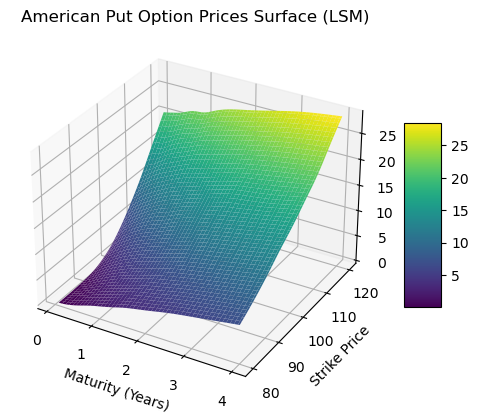

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def price_american_options():
    r = 0.03  # risk-free rate
    S0 = 100  # current stock price
    σ = 0.25  # volatility
    dim = 1_000  # number of simulation paths
    n = 504  # number of exercise rights per year
    seed = 42  # random seed for reproducibility
    poly_degree = 3  # polynomial degree for LSM regression
    # Define maturities and strikes
    maturities = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 15/12, 18/12, 2, 30/12, 3, 4])
    strikes = np.arange(0.8 * S0, 1.21 * S0, 0.05 * S0)

    # Lists to store results
    prices = []
    maturity_list = []
    strike_list = []

    # Iterate over each maturity and strike combination
    for T in maturities:
        for K in strikes:
            # Initialize the Monte Carlo pricer
            mcpricer = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)
            # Simulate the asset paths
            mcpricer.GeometricBrownianMotion_vec()
            # Price the option using LSM
            option_price = mcpricer.american_option_LSM(poly_degree, otype='put')

            # Store the results
            prices.append(option_price)
            maturity_list.append(T)
            strike_list.append(K)

    return prices, maturity_list, strike_list

# Call the function to get the results
prices, maturities, strikes = price_american_options()

# Convert lists to numpy arrays for processing
maturities_np = np.array(maturities)
strikes_np = np.array(strikes)
prices_np = np.array(prices)

# Creating a grid for maturities and strikes
maturity_grid, strike_grid = np.meshgrid(np.linspace(maturities_np.min(), maturities_np.max(), 100),
                                         np.linspace(strikes_np.min(), strikes_np.max(), 100))

# Interpolating the prices onto the grid
price_grid = griddata((maturities_np, strikes_np), prices_np, (maturity_grid, strike_grid), method='cubic')

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(maturity_grid, strike_grid, price_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Option Price')
plt.title('American Put Option Prices Surface (LSM)')
plt.colorbar(surface, ax=ax, shrink=0.5, aspect=5)  # Adding a color bar for reference

# Save the plot as a PNG file
plt.savefig('OptionsSurfaceLSM.png')

# Display the plot
plt.show()

In [34]:
t0 = time()
optionValues = price_american_options()  # calculate all values
t1 = time(); d1 = t1 - t0
print("Duration in Seconds %6.3f" % d1)

Maturity: 0.08 years, Strike: 80.00, American Put Option Price: 0.00
Maturity: 0.08 years, Strike: 85.00, American Put Option Price: 0.02
Maturity: 0.08 years, Strike: 90.00, American Put Option Price: 0.21
Maturity: 0.08 years, Strike: 95.00, American Put Option Price: 1.00
Maturity: 0.08 years, Strike: 100.00, American Put Option Price: 2.97
Maturity: 0.08 years, Strike: 105.00, American Put Option Price: 6.29
Maturity: 0.08 years, Strike: 110.00, American Put Option Price: 10.50
Maturity: 0.08 years, Strike: 115.00, American Put Option Price: 15.51
Maturity: 0.08 years, Strike: 120.00, American Put Option Price: 20.54
Maturity: 0.17 years, Strike: 80.00, American Put Option Price: 0.03
Maturity: 0.17 years, Strike: 85.00, American Put Option Price: 0.18
Maturity: 0.17 years, Strike: 90.00, American Put Option Price: 0.71
Maturity: 0.17 years, Strike: 95.00, American Put Option Price: 1.93
Maturity: 0.17 years, Strike: 100.00, American Put Option Price: 4.11
Maturity: 0.17 years, Str

# Runtime vs options-

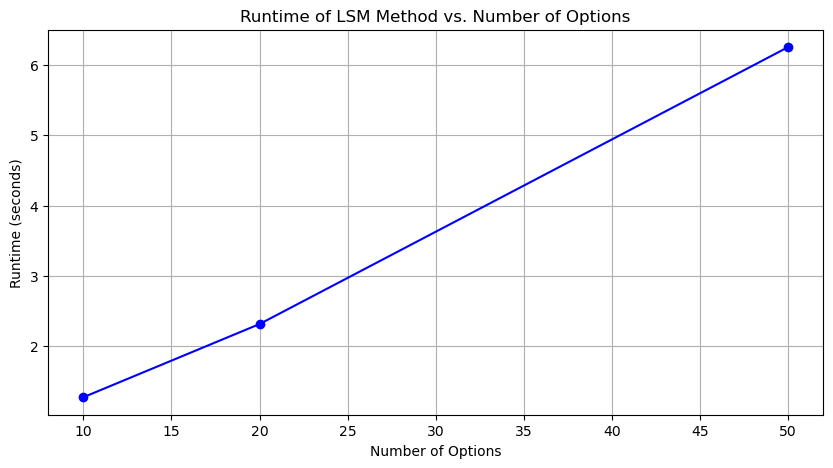

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

def price_american_options(S0, σ, r, dim, n, seed, poly_degree, maturities, strikes):
    # Lists to store results
    prices = []
    maturity_list = []
    strike_list = []

    # Iterate over each maturity and strike combination
    for T in maturities:
        for K in strikes:
            # Initialize the Monte Carlo pricer
            mcpricer = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)
            # Simulate the asset paths
            mcpricer.GeometricBrownianMotion_vec()
            # Price the option using LSM
            option_price = mcpricer.american_option_LSM(poly_degree, otype='put')

            # Store the results
            prices.append(option_price)
            maturity_list.append(T)
            strike_list.append(K)

    return prices, maturity_list, strike_list

# LSM runtime measurement
S0 = 100
σ = 0.25
r = 0.03
dim = 1000
n = 504
seed = 42
poly_degree = 3
maturities = np.array([1])  # Use a single maturity for simplicity

# Number of options to test
num_options_list = [10, 20, 50]
lsm_runtimes = []

for num_options in num_options_list:
    strikes = np.linspace(0.8 * S0, 1.2 * S0, num_options)

    start_time = time.time()
    _ = price_american_options(S0, σ, r, dim, n, seed, poly_degree, maturities, strikes)
    end_time = time.time()

    lsm_runtimes.append(end_time - start_time)

# Plotting Runtime vs. Number of Options
plt.figure(figsize=(10, 5))
plt.plot(num_options_list, lsm_runtimes, marker='o', color='blue')
plt.xlabel('Number of Options')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of LSM Method vs. Number of Options')
plt.grid(True)
plt.show()